In [1]:
# Download IMDB data from site -- http://ai.stanford.edu/~amaas/data/sentiment/
# p.234 of Python Machine Learning by Sebastian Raschka


In [2]:
import os
import pandas as pd

pwd = os.getcwd()
print(pwd)
file = os.listdir(pwd)

/Users/whs/Documents/DataJournalism/CongressionalTweets/whs2k.github.io


In [3]:
#################
# Start here    #
#################
#import pyprind

df = pd.read_csv(pwd+'/movie_data.csv', encoding='utf-8')
df.columns = ['review', 'sentiment']

print(df.shape)

(49999, 2)


In [4]:
df.head(10)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
5,Leave it to Braik to put on a good show. Final...,1
6,Nathan Detroit (Frank Sinatra) is the manager ...,1
7,"To understand ""Crash Course"" in the right cont...",1
8,I've been impressed with Chavez's stance again...,1
9,This movie is directed by Renny Harlin the fin...,1


In [5]:
df.loc[3]

review       hi for all the people who have seen this wonde...
sentiment                                                    1
Name: 3, dtype: object

# Prep Data

In [6]:
# Bag of Word model
# 1. create a vocabulary of unique tokens (or words)
# 2. construct a feature vector for each document, features store count
#    of words per document

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer() #Instanstiate the count array

docs = np.array(['The sun is shining', 
                 'The weather is sweet',
                 'The sun is shining and the weather is sweet'])

bag = count.fit_transform(docs)

print(count.vocabulary_)
print(bag.toarray())

{'the': 5, 'sun': 3, 'is': 1, 'shining': 2, 'weather': 6, 'sweet': 4, 'and': 0}
[[0 1 1 1 0 1 0]
 [0 1 0 0 1 1 1]
 [1 2 1 1 1 2 1]]


In [7]:
# tf(t,d) - raw term frequencies (t: term, d: nos times term t appears in doc d)
# tf-idf(t,d) - term frequency inverse document frequency
# tf-idf = tf(t,d) * idf(t,x)  = tf(t,d) * log( [1+nd]/[1+df(d,t)] ) 


In [8]:
# TfidTransformer
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer() #Instantiate Term Frequency invers

np.set_printoptions(precision=2)

print(tfidf.fit_transform(count.fit_transform(docs)).toarray()) #How much did the term appear in other documents?


[[ 0.    0.43  0.56  0.56  0.    0.43  0.  ]
 [ 0.    0.43  0.    0.    0.56  0.43  0.56]
 [ 0.4   0.48  0.31  0.31  0.31  0.48  0.31]]


In [9]:
# so if the term "the" shows up lots of times, does that mean it's important?
# how can we make terms that shows up lots of times across documents, less important
# let's normalize by the times these terms show up across documents.

# employ : [nos of docs containing term "the" ]/[total nos of documents]

# if term appear often, give it less emphasis

# tf-idf(t,d) = tf(t,2)*(idf(t,d)+1)
# with idf(t,d) = log ([1+total nos of docs]/[1+nos of docs containing term t])


In [10]:
#Reg functions...to get rid of HTML Tags and emoticons

import re
def preprocessor(text): 
# find '<' then anything not '>' [^>], [^>]* 0 or more prefix, then close with '>'    
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) 
    # eyes[:,;,=], optional nose [-], and mouth[),(,D,P)]
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

In [11]:
tmp = 'is ;) :) seven.<br /><br />Title (Brazil): Not Available'

print(preprocessor(tmp))
#print(preprocessor('</a>This :) is :( a test :-)!' ))
#print(re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', '</a>This :) is :( a test :-)!'))

is seven title brazil not available;) :)


In [12]:
df['review'] = df['review'].apply(preprocessor) #use the apply method and send in the preprocessor function (applys the function to each row)


In [13]:
df.shape

(49999, 2)

In [14]:
df.tail(3)

,review,sentiment
49996,i don t even know where to begin on this one i...,0
49997,richard tyler is a little boy who is scared of...,0
49998,i waited long to watch this movie also because...,1


In [15]:
# p.242 Processing documents into tokens
# split the sentence/corpora into individual elements
def tokenizer(text):
    return text.split()

In [16]:
tokenizer('running like running and thus they run')

['running', 'like', 'running', 'and', 'thus', 'they', 'run']

In [17]:
# word stemming, tranforming word into their root form
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [18]:
tokenizer_porter('running like running and thus they run')


['run', 'like', 'run', 'and', 'thu', 'they', 'run']

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/whs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
from nltk.corpus import stopwords
stop = stopwords.words('english')  # stop words have little meaning eg. a, is, and, has, etc. 
[w for w in tokenizer_porter('a runner likes running and runs a lot') 
 if w not in stop]

['runner', 'like', 'run', 'run', 'lot']

# Let's Do Some ML

In [21]:
# pg. 244 of Python Machine Learning by Sebastian Raschka
# Training a Logistic Regression model for document classification

#Test/Train
# (X,y)


X = df.loc[:, 'review'].values
y  = df.loc[:, 'sentiment'].values

X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values

X_test  = df.loc[25000:, 'review'].values
y_test  = df.loc[25000:, 'sentiment'].values

print(y_test.shape)

(24999,)


#Find the Best Parameters using automation!

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
tfidf = TfidfVectorizer(strip_accents = None, 
                       lowercase = False)


In [24]:
#Optimize to find best params

param_grid = [
              {'vect__ngram_range':[(1,1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer], #, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [100]}, # 0.1, 1.0, 10.0, 100.0]},
              
              {'vect__ngram_range': [(1,1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer], #, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C':[100]} #[0.1, 1.0,10.0,100.0]}
                ]


In [25]:
lr_tfidf = Pipeline([ ('vect', tfidf) ,
                      ('clf',  LogisticRegression(random_state=0))])



In [26]:
gs_lr_tfidf = GridSearchCV( lr_tfidf, param_grid, #sends each subset to a different core
                          scoring = 'accuracy',
                          cv = 5, verbose = 1,
                          n_jobs = -1) # n_jobs -1 uses all computer cores

In [27]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(25001,) (25001,)
(24999,) (24999,)


In [28]:
#Takes like 60 seconds

gs_lr_tfidf.fit(X_train, y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'vect__ngram_range': [(1, 1)], 'vect__stop_words': [['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', '...8>], 'vect__use_idf': [False], 'vect__norm': [None], 'clf__penalty': ['l1', 'l2'], 'clf__C': [100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
    

#Results

In [29]:
print('The Best parameter set: %s' % gs_lr_tfidf.best_params_)


The Best parameter set: {'clf__C': 100, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x10ea5cae8>}


In [30]:
print('CV Accuracy: %.3f'
     % gs_lr_tfidf.best_score_)
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))


CV Accuracy: 0.890
Test Accuracy: 0.893


In [31]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


In [33]:
#Learning Curve, Takes Forever; Skip

#estimator = gs_lr_tfidf

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
#cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)


#title = "Learning Curve (LogReg, $\IMDB$)"
### SVC is more expensive so we do a lower number of CV iterations:
#plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)

#plt.show()



# Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier

rf_clf=RandomForestClassifier(max_depth=None)
#tree_clf.fit(X,y)
print(rf_clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [65]:
rf_tfidf = Pipeline([ ('vect', tfidf) ,
                      ('clf',  rf_clf)])



In [66]:
rf_tfidf.fit(X_train, y_train) 

Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [67]:
#from sklearn.model_selection import cross_val_score
#cv_scores = cross_val_score(rf_tfidf, X, y, cv=10)
#print(cv_scores)
#print(np.mean(cv_scores))


[ 0.75  0.75  0.74  0.77  0.76  0.76  0.75  0.75  0.75  0.74]
0.750234726945


# Importing Data - Tweet Time

#Data Prep

In [34]:
import datetime as dt
from datetime import date, timedelta

#Ceate a vaiarble: todays_tweets = 
today=dt.datetime.today().strftime("%Y-%m-%d")
yesterday = str(dt.date.today() - timedelta(1))
yesterday_json=(yesterday +  '.json')
url='https://alexlitel.github.io/congresstweets/data/'
url_json= (url + yesterday_json)
print(url_json)

https://alexlitel.github.io/congresstweets/data/2017-08-06.json


In [35]:
#Create Dates / A-axis
from datetime import date
d1 = date(2017, 6, 22)
d0 = date.today()
delta = d0 - d1
periods=delta.days
dates = pd.date_range('20170622', periods=periods)
print(dates)


DatetimeIndex(['2017-06-22', '2017-06-23', '2017-06-24', '2017-06-25',
               '2017-06-26', '2017-06-27', '2017-06-28', '2017-06-29',
               '2017-06-30', '2017-07-01', '2017-07-02', '2017-07-03',
               '2017-07-04', '2017-07-05', '2017-07-06', '2017-07-07',
               '2017-07-08', '2017-07-09', '2017-07-10', '2017-07-11',
               '2017-07-12', '2017-07-13', '2017-07-14', '2017-07-15',
               '2017-07-16', '2017-07-17', '2017-07-18', '2017-07-19',
               '2017-07-20', '2017-07-21', '2017-07-22', '2017-07-23',
               '2017-07-24', '2017-07-25', '2017-07-26', '2017-07-27',
               '2017-07-28', '2017-07-29', '2017-07-30', '2017-07-31',
               '2017-08-01', '2017-08-02', '2017-08-03', '2017-08-04',
               '2017-08-05', '2017-08-06'],
              dtype='datetime64[ns]', freq='D')


In [36]:
#Change Dates to string fo manipulation
datesStr=dates.strftime('%Y-%m-%d')

In [69]:
#Cread new pivot table dfPlot
dfPlot = pd.DataFrame()
dfPlot['ScoreLR', 'scoresRF']=0
scoresLR=[]
scoresRF=[]

#Loop to import and predict each day from URL

In [70]:
import json
import urllib
import urllib.request


for date in datesStr:
    i=0
    date_json=date+'.json'
    url='https://alexlitel.github.io/congresstweets/data/'
    url_json=url+date_json
    data = urllib.request.urlopen(url_json).read()
    output = json.loads(data)
    dfJson = pd.DataFrame(output)
    predictLR = np.mean(clf.predict(dfJson['text']))
    predictRF = np.mean(rf_tfidf.predict(dfJson['text']))
    scoresLR=np.append(scoresLR,predictLR)
    scoresRF=np.append(scoresRF,predictRF)
    i+=1
    print('sucess '+date)



sucess 2017-06-22
sucess 2017-06-23
sucess 2017-06-24
sucess 2017-06-25
sucess 2017-06-26
sucess 2017-06-27
sucess 2017-06-28
sucess 2017-06-29
sucess 2017-06-30
sucess 2017-07-01
sucess 2017-07-02
sucess 2017-07-03
sucess 2017-07-04
sucess 2017-07-05
sucess 2017-07-06
sucess 2017-07-07
sucess 2017-07-08
sucess 2017-07-09
sucess 2017-07-10
sucess 2017-07-11
sucess 2017-07-12
sucess 2017-07-13
sucess 2017-07-14
sucess 2017-07-15
sucess 2017-07-16
sucess 2017-07-17
sucess 2017-07-18
sucess 2017-07-19
sucess 2017-07-20
sucess 2017-07-21
sucess 2017-07-22
sucess 2017-07-23
sucess 2017-07-24
sucess 2017-07-25
sucess 2017-07-26
sucess 2017-07-27
sucess 2017-07-28
sucess 2017-07-29
sucess 2017-07-30
sucess 2017-07-31
sucess 2017-08-01
sucess 2017-08-02
sucess 2017-08-03
sucess 2017-08-04
sucess 2017-08-05
sucess 2017-08-06


In [71]:
dfPlot.head()
predict
print(scoresLR, scoresRF)

[ 0.53  0.53  0.61  0.57  0.5   0.53  0.52  0.53  0.56  0.56  0.5   0.54
  0.72  0.56  0.56  0.53  0.57  0.51  0.52  0.55  0.54  0.5   0.51  0.59
  0.51  0.52  0.5   0.53  0.53  0.56  0.57  0.52  0.54  0.47  0.49  0.49
  0.5   0.57  0.51  0.52  0.53  0.55  0.54  0.59  0.55  0.59] [ 0.68  0.71  0.65  0.68  0.69  0.7   0.72  0.73  0.75  0.73  0.71  0.75
  0.79  0.76  0.76  0.76  0.74  0.73  0.75  0.75  0.73  0.73  0.71  0.76
  0.68  0.73  0.72  0.73  0.75  0.75  0.76  0.74  0.72  0.68  0.72  0.7
  0.71  0.77  0.7   0.73  0.76  0.76  0.76  0.76  0.76  0.76]


Congress Mood Today is:


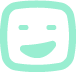

In [72]:
#set pictue
#Picture Cedits Alina Oleynik
from IPython.display import Image
Smiley=Image("Smiley.png")
Frowney=Image("Frowney.png")

if predictLR > .5:
    todaysFacePic = Smiley 
else:
    todaysFacePic = Frowney

# write image to png
fh = open('todaysFacePic.png','w')
fh.write('todaysFacePic.png')
fh.close()

#import urllib.request
#with urllib.request.urlopen('https://github.com/whs2k/whs2k.github.io/blob/master/Frowney.png?raw=true') as url:
#   facePic = url.read()
 
print('Congress Mood Today is:')
todaysFacePic

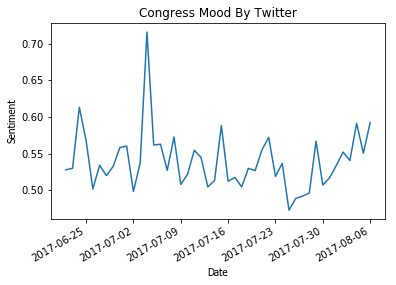

In [73]:
#https://matplotlib.org/users/recipes.html

import matplotlib.pyplot as plt
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
thfont = {'fontname':'Tahoma'}

plt.clf()


fig, ax = plt.subplots(1)
ax.plot(dates, scoresLR)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()

import matplotlib.dates as mdates
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.title('Congress Mood By Twitter')

plt.xlabel('Date',**thfont)
plt.ylabel('Sentiment',**thfont)
plt.savefig(pwd+'/todaysMood.svg', ppi=1200)
plt.show()
plt.close()



# Add in Party Information - TBD

In [42]:
#dfAccts = pd.read_csv(pwd+'/congressTwitters.csv')
#dfNames = pd.read_csv(pwd+'/congressNames.csv')
#dfNames.head()
#dfNames.drop[4]
#dfNames.dropna()#

# Prepping and Automating this Script

In [43]:
#Convert this notebook to a script
#$ ipython nbconvert --to script "congressTweets.ipynb"

#Then Execute
#$ python "congressTweets.py"




In [44]:
#Automate it
#http://naelshiab.com/tutorial-how-to-automatically-run-your-scripts-on-your-computer/
#1. Create a new text file: 
#    #!/bin/sh
#    python python /Users/whs/Documents/DataJournalism/CongressionalTweets/whs2k.github.io/congressTwitter.py
#2. Save it with no extension
#3. Convert it to an excecutable 
#    chmod 755 command
#4. Set it up as an app in automater
#5. Make it an alert on calender

In [45]:
# Automate a git file
#Last you need to git
#git add ..
#git commit -m "daily update"
#git push